# Evaluation du coût d'un trajet

Dans ce notebook, nous estimons les paramètres du coût d'un trajet. Pour cela, nous utilusons les données récoltées dans notre formulaire: le point de départ, le point d'arrivée, la tranche horaire du déplacement ainsi que el coût

> [!IMPORTANT]
> Avant d'exécuter les cellules suivantges, vous devez d'abord installer les dépendances du projet avec la commande `pip install requirements.txt`

## Chargement et exploration du dataset

In [8]:
import pandas as pd

In [48]:
df = pd.read_csv('Collecte de données de transport dans la ville de Yaoundé..csv')
df

,Horodateur,Précisez le coût du trajet en FCFA,Rappelez-vous d'un trajet que vous avez eu à faire dans la ville de Yaoundé via un taxi 🚕 🚖.\n\nIndiquez le lieu de départ du trajet:,Indiquez la destination :,Précisez la tranche horaire de l'heure de départ:
0,2024/12/01 5:40:22 PM UTC+1,NaN,Polytechnique,Jouvence,15h30 - 18h59
1,2024/12/01 5:41:03 PM UTC+1,NaN,Mvan,Melen,05h00 - 06h59
2,2024/12/01 5:44:32 PM UTC+1,500,Mvan,Melen,07h00 - 08h59
3,2024/12/01 5:45:00 PM UTC+1,400,Melen,Mvan,09h00 - 13h59
4,2024/12/01 5:46:24 PM UTC+1,500,Carrefour Scalom,Carrefour nkoabang,09h00 - 13h59
5,2024/12/01 5:51:29 PM UTC+1,500fcfa,Melen,Nkoabang,15h30 - 18h59
6,2024/12/01 6:02:13 PM UTC+1,350,Mendong,CHU,07h00 - 08h59
7,2024/12/01 6:11:28 PM UTC+1,400,Jouvence,Melen,07h00 - 08h59
8,2024/12/01 6:14:35 PM UTC+1,600,Simbock,Melen,07h00 - 08h59
9,2024/12/01 6:15:03 PM UTC+1,350,Cite u,Simbock,14h00 - 15h29


Le dataset contient d'abord des oms de colonnes assez long, ce qui est norml vu que Google pour passer de forms à Sheets attribue les noms de questions aux colonnes.
Nous allons d'abord les renommer. Ensuite, Google Sheets ajoute aussi la colonne Horodateur qui indique l'heure à laquelle le formulaire a été  rempli, ce qui ne nous aide pas du tout dans notre étude, nous la supprimons donc.

In [13]:
# Renommer les colonnes
df = df.rename(columns={
    "Précisez le coût du trajet en FCFA": "cost",
    "Rappelez-vous d'un trajet que vous avez eu à faire dans la ville de Yaoundé via un taxi 🚕 🚖.\n\nIndiquez le lieu de départ du trajet:": "start",
    "Indiquez la destination :": "end",
    "Précisez la tranche horaire de l'heure de départ:": "hour"
})

# Supprimer la colonne "Horodateur"
df = df.drop(columns=["Horodateur"])

df.head(5)


,cost,start,end,hour
0,NaN,Polytechnique,Jouvence,15h30 - 18h59
1,NaN,Mvan,Melen,05h00 - 06h59
2,500,Mvan,Melen,07h00 - 08h59
3,400,Melen,Mvan,09h00 - 13h59
4,500,Carrefour Scalom,Carrefour nkoabang,09h00 - 13h59


Le dataset est un peu plus clair, mais il reste néanmoins mal formaté car les données actuelles sont mal formatées, donc sont inexploitables.
Nous allons donc:
- Supprimer les entrées contenant NaN dans le dataset
- Formater le coût (500frs => 500)
- Mapper chaque tranche horaire à un nombre entier de 1 à 8 

In [14]:
# Supprimer les entrées avec un coût NaN ou contenant uniquement des chaînes sans chiffres
df = df.dropna(subset=["cost"])  # Supprimer les lignes avec NaN dans la colonne "cost"
df = df[df["cost"].str.contains(r'\d', na=False)]  # Conserver uniquement les lignes contenant des chiffres

# Extraire la partie numérique du coût
df["cost"] = df["cost"].str.extract(r'(\d+)', expand=False).astype(int)

df.head(5)


,cost,start,end,hour
2,500,Mvan,Melen,07h00 - 08h59
3,400,Melen,Mvan,09h00 - 13h59
4,500,Carrefour Scalom,Carrefour nkoabang,09h00 - 13h59
5,500,Melen,Nkoabang,15h30 - 18h59
6,350,Mendong,CHU,07h00 - 08h59


In [15]:
# Dictionnaire de mappage des plages horaires aux entiers
hour_mapping = {
    "Minuit - 04h59": 1,
    "05h00 - 06h59": 2,
    "07h00 - 08h59": 3,
    "09h00 - 13h59": 4,
    "14h00 - 15h29": 5,
    "15h30 - 18h59": 6,
    "19h00 - 21h00": 7,
    "21h01 - 23h59": 8
}

# Remplacer les plages horaires par les entiers
df["hour"] = df["hour"].map(hour_mapping).astype(int)

df.head(5)


,cost,start,end,hour
2,500,Mvan,Melen,3
3,400,Melen,Mvan,4
4,500,Carrefour Scalom,Carrefour nkoabang,4
5,500,Melen,Nkoabang,6
6,350,Mendong,CHU,3


## Numérisation des données de géolocalisation

Cette partie est très cruciale pour notre travail, car il s'agit ici de changer les valeurs des points de départ et d'arrivée en latitudes et longitudes.

In [16]:
import requests # Pour requêter une API
from geopy.distance import geodesic

In [17]:
# Fonction pour obtenir les coordonnées à partir d'un quartier
def get_coordinates(neighborhood, city="Yaoundé", country="Cameroon"):
    address = f"{neighborhood}, {city}, {country}"
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": address,
        "format": "json",
        "limit": 1
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200 and response.json():
        data = response.json()[0]
        return float(data["lon"]), float(data["lat"])  # Renvoie (longitude, latitude)
    else:
        return None, None


La fonction que ous avons défini nous permet de passer d'un point écrit comme une String à sson couple de coordonnées géographiques eb utilisant l'API d'OpenStreetMap

Nous allons donc initier un nouveau dataframe `data` qui contiendra nos données numériques

In [18]:
data = df.copy()

# Initialiser les nouvelles colonnes
data["start_long"] = None
data["start_lat"] = None
data["end_long"] = None
data["end_lat"] = None
data["distance"] = None

# Parcourir chaque ligne pour effectuer les transformations
for index, row in data.iterrows():
    # Obtenir les coordonnées du lieu de départ
    start_long, start_lat = get_coordinates(row["start"])
    # Obtenir les coordonnées du lieu de destination
    end_long, end_lat = get_coordinates(row["end"])
    
    # Mettre à jour les colonnes de coordonnées
    data.at[index, "start_long"] = start_long
    data.at[index, "start_lat"] = start_lat
    data.at[index, "end_long"] = end_long
    data.at[index, "end_lat"] = end_lat
    
    # Calculer la distance si les coordonnées sont disponibles
    if start_lat and start_long and end_lat and end_long:
        start_coords = (start_lat, start_long)
        end_coords = (end_lat, end_long)
        data.at[index, "distance"] = geodesic(start_coords, end_coords).kilometers

# Garder uniquement les colonnes nécessaires
data = data[["start_long", "start_lat", "end_long", "end_lat", "distance", "cost", "hour"]]

data.head(5)

,start_long,start_lat,end_long,end_lat,distance,cost,hour
2,11.516337,3.822583,11.496399,3.864589,5.145869,500,3
3,11.496399,3.864589,11.516337,3.822583,5.145869,400,4
4,None,None,None,None,None,500,4
5,11.496399,3.864589,None,None,None,500,6
6,11.472698,3.834643,11.496076,3.86275,4.049872,350,3


In [19]:
data

,start_long,start_lat,end_long,end_lat,distance,cost,hour
2,11.516337,3.822583,11.496399,3.864589,5.145869,500,3
3,11.496399,3.864589,11.516337,3.822583,5.145869,400,4
4,None,None,None,None,None,500,4
5,11.496399,3.864589,None,None,None,500,6
6,11.472698,3.834643,11.496076,3.86275,4.049872,350,3
7,11.482033,3.830017,11.496399,3.864589,4.142619,400,3
8,11.476172,3.809866,11.496399,3.864589,6.454839,600,3
9,None,None,11.476172,3.809866,None,350,5
10,11.476172,3.809866,None,None,None,400,8
11,None,None,11.476172,3.809866,None,400,7


On remarque que OSM ne nous renvoie pas toutes les coordonnées de certains points. Pour l'instant, nous les supprimerons.

In [20]:
data_cleaned = data.dropna()
data_cleaned

,start_long,start_lat,end_long,end_lat,distance,cost,hour
2,11.516337,3.822583,11.496399,3.864589,5.145869,500,3
3,11.496399,3.864589,11.516337,3.822583,5.145869,400,4
6,11.472698,3.834643,11.496076,3.86275,4.049872,350,3
7,11.482033,3.830017,11.496399,3.864589,4.142619,400,3
8,11.476172,3.809866,11.496399,3.864589,6.454839,600,3
16,11.496399,3.864589,11.541007,3.906918,6.815796,400,5
17,11.496399,3.864589,11.541007,3.906918,6.815796,500,6
18,11.496399,3.864589,11.53409,3.841615,4.896768,300,5
19,11.53409,3.841615,11.496399,3.864589,4.896768,400,7
20,11.53409,3.841615,11.496399,3.864589,4.896768,300,4


In [45]:
lon, lat = get_coordinates('polytech')
lon
lat

3.8626008

Nous avons ainsi un dataset numérique, prêt à être exploité.

## Visualisation des données

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

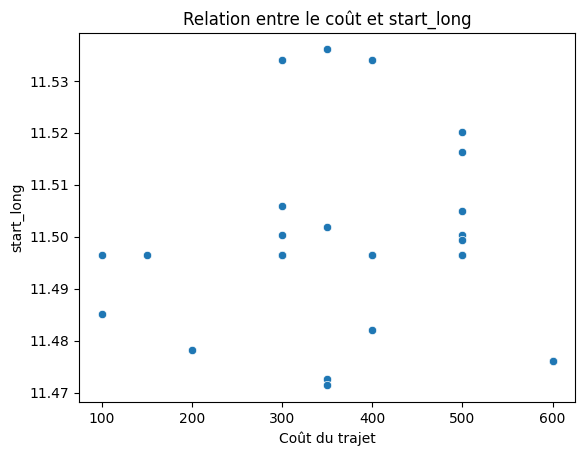

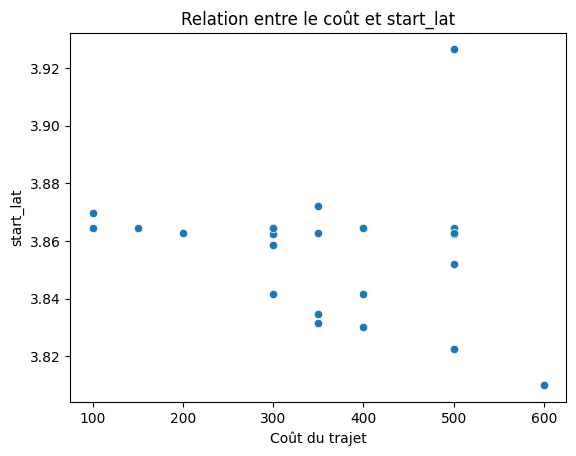

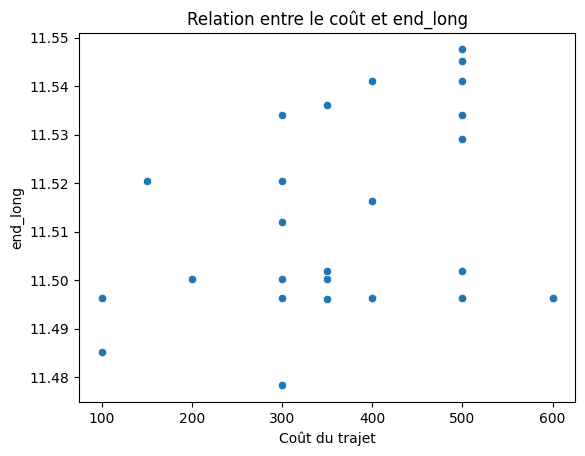

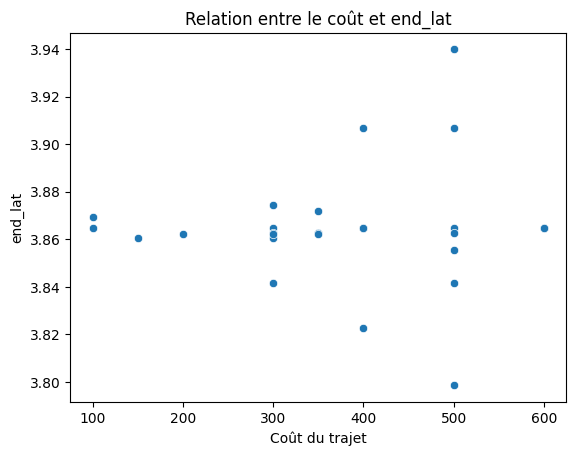

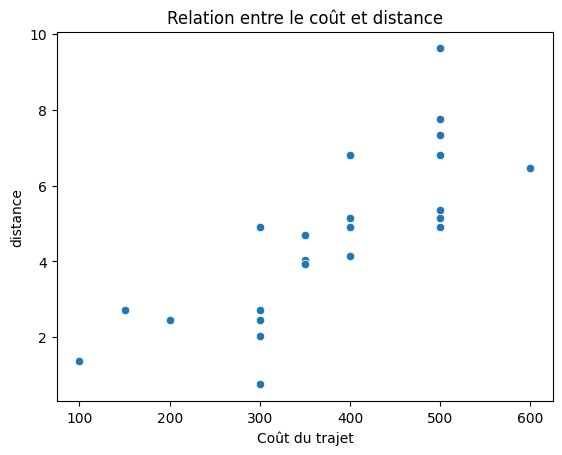

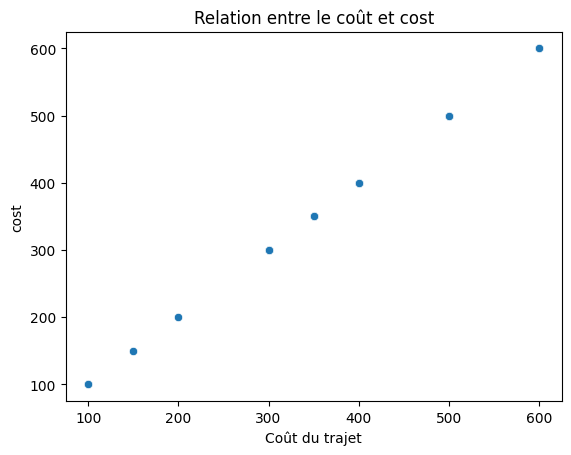

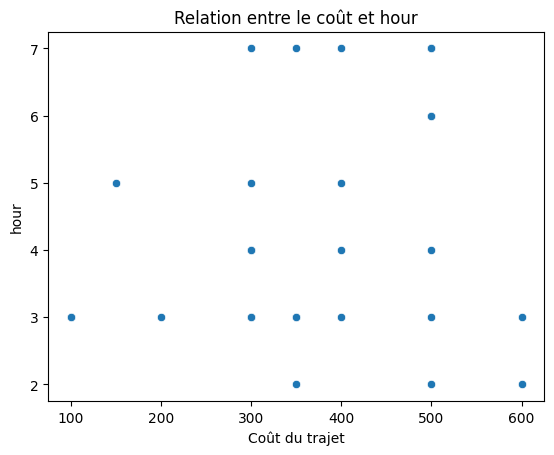

In [23]:
for col in data_cleaned.columns:
    sns.scatterplot(x=data_cleaned['cost'], y=data[col])
    plt.xlabel('Coût du trajet')
    plt.ylabel(col)
    plt.title('Relation entre le coût et ' + col)
    plt.show()

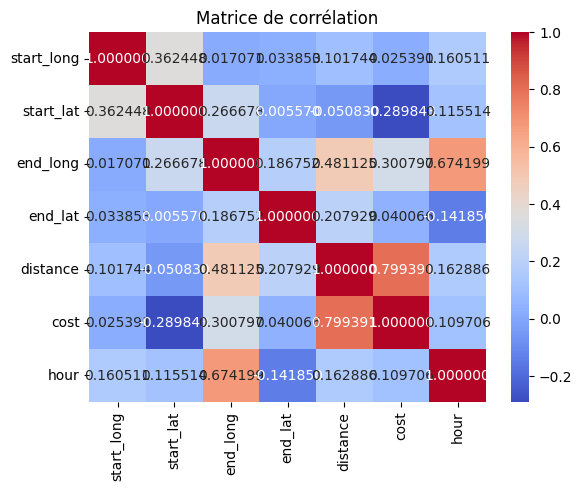

In [31]:
corr = data_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='2f')
plt.title('Matrice de corrélation')
plt.show()

> [!NOTE]
> Cette matrice montre qu'il existe une forte corrélation entre la distance et le prix du trajet

## Estimation des paramètres

Nous commençons par séparer les features du target

In [32]:
X=data_cleaned[['start_long', 'start_lat', 'end_long', 'end_lat', 'distance', 'hour']]
y=data_cleaned['cost']

Ensuite, nous séparons les données de test et celles d'entraînement

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

### Regréssion linéaire

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [37]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Erreur quadratique moyenne: {mse}')

Erreur quadratique moyenne: 21401.581389402585


In [38]:
y_pred

array([592.04436068, 203.46912986, 548.12857537, 517.94042044,
       542.58252113])

In [39]:
y_test

19    400
25    200
20    300
34    600
2     500
Name: cost, dtype: int64

### Forêts aléatoires

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Mean Squared Error (Random Forest):", mse_rf)

Mean Squared Error (Random Forest): 2915.7


In [43]:
y_pred_rf

array([423.5, 245.5, 388. , 546. , 464. ])

### Exemple de prédiction extra-dataset

In [47]:
dep = 'polytech'
arr = 'simbock'

lon_dep, lat_dep = get_coordinates(dep)
lon_arr, lat_arr = get_coordinates(arr)
hour = 4
deps= (lon_dep, lat_dep)
arrs = (lon_arr, lat_arr)
distance = geodesic(deps, arrs).kilometers
test = [[lon_dep, lat_dep, lon_arr, lat_arr, distance, hour]]
cost = rf_model.predict(test)
cost

/home/nameless/Documents/AdminR/Cost calculation/env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([491.5])